### This assignment uses a convolutional neural network for image colorization whichturns a grayscale image to a colored image.5 By converting an image to grayscale,we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Downolad the dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.


In [1]:
import tensorflow

import keras
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Reshape, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from skimage import io

Using TensorFlow backend.


### (b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


cou=0
count=0
X_train_bird=np.zeros((5000,32,32,3))

In [4]:
for class_y in y_train:
    if(class_y == 2):
        X_train_bird[cou] = x_train[count]
        cou=cou+1
    count=count+1
X_train_bird.shape

(5000, 32, 32, 3)

In [5]:
p=0
q=0
X_test_bird=np.zeros((1000,32,32,3))

for class_y in y_test:
    if(class_y == 2):
        X_test_bird[p] = x_test[q]
        p=p+1
    q=q+1
X_test_bird.shape

(1000, 32, 32, 3)

#### (c) Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.





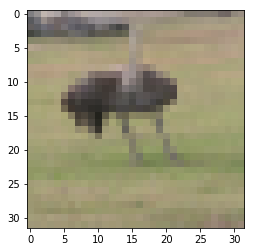

In [6]:
train_x_b=np.concatenate((X_train_bird,X_test_bird))
train_x_b.shape

new_x=np.uint8(train_x_b)
plt.imshow(new_x[5])
plt.show()

train_x_reshape= np.reshape(np.ravel(train_x_b), (6144000,3))

k_means = KMeans(n_clusters=4, random_state=0,n_init = 5).fit(train_x_reshape)
dist = k_means.transform(train_x_reshape)

### (d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel’s value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

In [7]:
k_means.cluster_centers_

centers=np.uint8(k_means.cluster_centers_)

In [8]:
index = np.array(range(len(centers))).reshape(-1, 4)
plab = k_means.labels_
k_color_images = []
for i in plab:
    k_color_images.append(np.uint8(k_means.cluster_centers_[i]))
    
new_col_img= np.reshape(k_color_images, (6000,32,32,3))

color_labels = np.reshape(k_color_images, (6000,3072))


centers

array([[108, 108,  82],
       [206, 211, 211],
       [156, 155, 135],
       [ 49,  50,  38]], dtype=uint8)

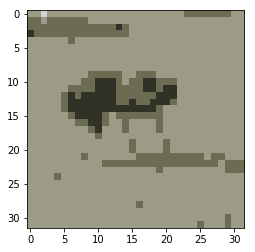

In [9]:
new_x=np.uint8(train_x_b)
plt.imshow(new_col_img[5])
plt.show()

In [10]:
shaped_plab=np.reshape(plab, (6000,1024))
new_plab = np_utils.to_categorical(shaped_plab)
new_plab= np.reshape(new_plab, (6000,4096))

print(shaped_plab[0])
print(new_plab[0])

[2 0 0 ... 0 0 0]
[0. 0. 1. ... 0. 0. 0.]


#### (e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images. The grayscale images are inputs of your network.

#### (f) Set up a deep convolutional neural network with two convolution layers (or more) and two (or more) MLP layers. Use 5 × 5 filters and a softmax output layer. Determine the number of filters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. Use a classification scheme, which means your output must determine one of the k = 4 color classes for each pixel in your grayscale image. Your input is a grayscale version of an image (32 × 32 × 1) and the output is 32 × 32 × 4. The output assigns one of the k = 4 colors to each of the 32 × 32 pixels; therefore, each of the pixels is classified into one of the classes [1 0 0 0], [0 1 0 0], [0 0 1 0], [0 0 0 1]. After each pixel is classified into one of the main colors, the RGB code of that color can be assigned to the pixel. For example, if the third main color 7 is [255 255 255] and pixel (32,32) of an image has the one-hot encoded class [0 0 1 0], i.e it was classified as the third color, the (32,32) place in the output can be associated with [255 255 255]. The size of the output of the convolutional part, c1 × c2 depends on the size of the convolutional layers you choose and is a feature map, which is a matrix. That matrix must be flattened or reshaped, i.e. must be turned into a vector of size c1c2 ×1, before it is fed to the MLP part. Choose the number of neurons in the first layer of the MLP (and any other hidden layers, if you are willing to have more than one hidden layer) yourself, but the last layer must have 32 × 32 × 4 = 4096 neurons, each of which represents a pixel being in one of the k = 4 classes. Add a softmax layer8 which will choose the highest value out of its k = 4 inputs for each of the 1024 pixels; therefore, the output of the MLP has to be reshaped into a 32 × 32 × 4 matrix, and to get the colored image, the RGB vector of each of the k = 4 classes has to be converted to the RGB vector, so an output image will be 32 × 32 × 3. Train at least for 5 epochs (30 epochs is strongly recommended). Plot training, (validation), and test errors in each epoch. Report the train and test errors and visually compare the artificially colored versions of the first 10 images in the test set with the original images.

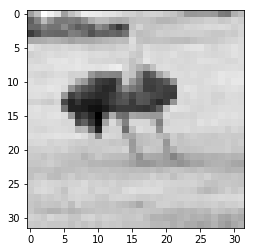

(5000, 4096)

In [11]:
import cv2

from skimage.color import rgb2gray
grey_data = rgb2gray(train_x_b)
plt.imshow(grey_data[5],cmap='gray')
plt.show()

grey_data = np.reshape(grey_data, (6000,32,32,1))
grey_data.shape

xtrain = grey_data[:5000]
x_grey_test = grey_data[5000:6000]
y_train_grey = new_plab[:5000]
y_grey_test = new_plab[5000:6000]
y_train_grey.shape

In [14]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=xtrain[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.20))
#model.add(Reshape((1024, 4)))
model.add(Activation('softmax'))
model.compile(optimizer="adam",loss="categorical_crossentropy")

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              6557696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
__________

In [16]:
from keras.callbacks import ModelCheckpoint
class eval_func(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        test_error = self.model.evaluate(x, y, verbose=0)
        self.test_loss.append(test_error)
        print('\nTest Error/Loss: {}\n'.format(test_error))
        
    def return_test(self):
        return self.test_loss

In [17]:
evaluate_model_func = eval_func((x_grey_test,y_grey_test))
filepath="model_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
funcs = [checkpoint, evaluate_model_func]

In [19]:
Model=model.fit(xtrain, y_train_grey,batch_size=256,validation_data=(x_grey_test,y_grey_test),callbacks=funcs,shuffle=True,epochs=15,verbose=1)



Train on 5000 samples, validate on 1000 samples
Epoch 1/15
5000/5000 [==============================] - 16s 3ms/step - loss: 11284.4451 - val_loss: 8515.0559

Epoch 00001: val_loss improved from inf to 8515.05594, saving model to model_weights.hdf5

Test Error/Loss: 8515.0554609375

Epoch 2/15
5000/5000 [==============================] - 14s 3ms/step - loss: 8510.5263 - val_loss: 8501.6977

Epoch 00002: val_loss improved from 8515.05594 to 8501.69770, saving model to model_weights.hdf5

Test Error/Loss: 8501.697515625

Epoch 3/15
5000/5000 [==============================] - 14s 3ms/step - loss: 8490.7030 - val_loss: 8467.9874

Epoch 00003: val_loss improved from 8501.69770 to 8467.98742, saving model to model_weights.hdf5

Test Error/Loss: 8467.987734375

Epoch 4/15
5000/5000 [==============================] - 14s 3ms/step - loss: 8467.3617 - val_loss: 8436.5213

Epoch 00004: val_loss improved from 8467.98742 to 8436.52127, saving model to model_weights.hdf5

Test Error/Loss: 8436.5214

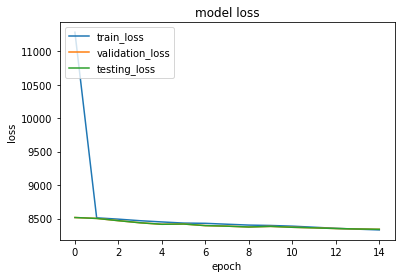

In [30]:
train_error=Model.history['loss']
test_error=evaluate_model_func.return_test()
val_error=Model.history['val_loss']
plt.plot(train_error)
plt.plot(test_error)
plt.plot(val_error)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss','testing_loss'], loc='upper left')
plt.show()

1024


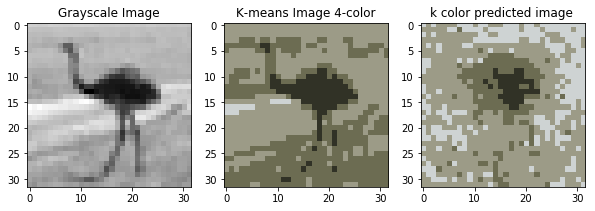

1024


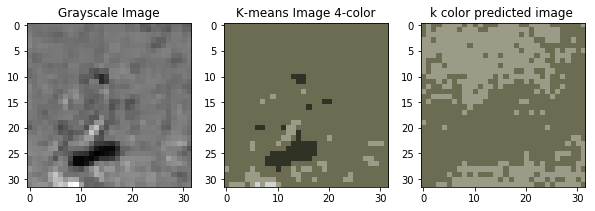

1024


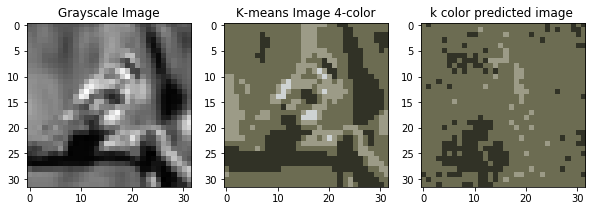

1024


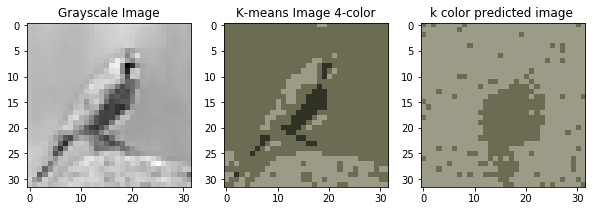

1024


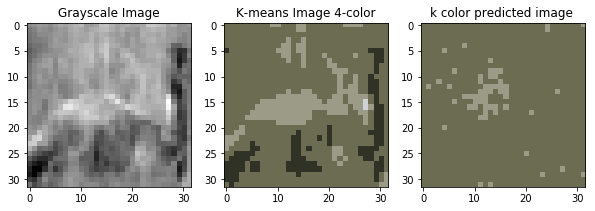

1024


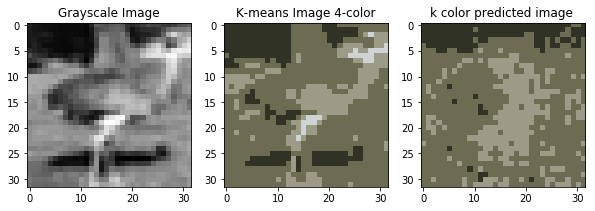

1024


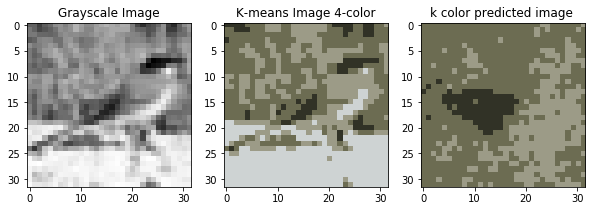

1024


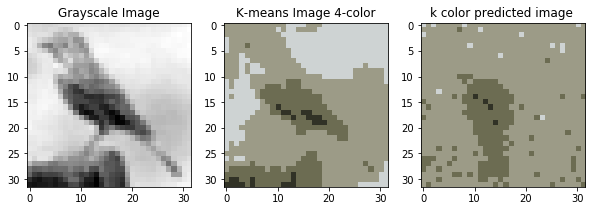

1024


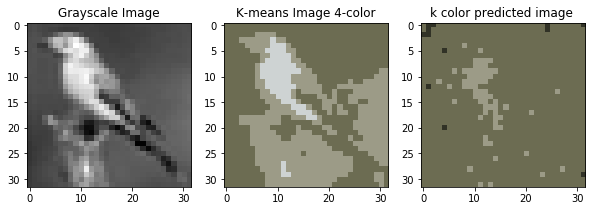

1024


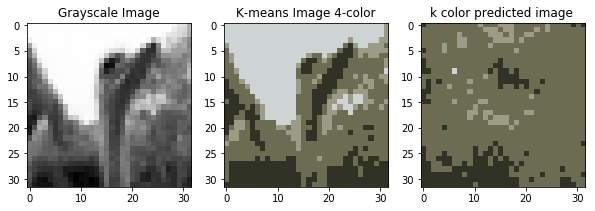

In [33]:
for i in range(50,60):
    
    pred = model.predict(x_grey_test[i:i+1])
    pred = np.reshape(pred,(1024,4))
    pred_labels = np.argmax(pred,axis = 1)
    print(len(pred_labels))
    k_color_pred = []
    for k in pred_labels:
        k_color_pred.append(np.uint8(k_means.cluster_centers_[k]))
    k_color_pred_shaped = np.reshape(k_color_pred,(32,32,3))
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,3)
    plt.title('k color predicted image ')
    plt.imshow(k_color_pred_shaped)
    plt.subplot(1,3,2)
    plt.title("K-means Image 4-color")
    plt.imshow(new_col_img[5000+i])
    plt.subplot(1,3,1)
    plt.title("Grayscale Image")
    plt.imshow(np.reshape(x_grey_test[i:i+1],(32,32)),cmap='gray')
    plt.show()